# Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import string
from string import digits
from tensorflow.keras import layers

# Importing Helper Functions

In [2]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-02-26 20:24:20--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-26 20:24:20 (65.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [46]:
# Import calculate_results helper function
from helper_functions import calculate_results,create_tensorboard_callback,plot_loss_curves

# Data Loading

In [4]:
df = pd.read_csv('bbc-text.csv')

In [5]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [6]:
df.shape

(2225, 2)

In [9]:
df.isnull().mean()

category    0.0
text        0.0
dtype: float64

# Data Pre processing

In [10]:
# To lower case
df['text'] = df['text'].map(lambda x: x.lower())
df['category'] = df['category'].map(lambda x: x.lower())

In [12]:
# Remove all Special characters
exclude = set(string.punctuation)
df['text'] = df['text'].map(lambda x: ''.join(ch for ch in x if ch not in exclude))
df['category'] = df['category'].map(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [13]:
# Remove all numbers from text 
remove_digits = str.maketrans('','',digits)
df['text'] = df['text'].map(lambda x: x.translate(remove_digits))
df['category'] = df['category'].map(lambda x: x.translate(remove_digits))

# Split the Data

In [14]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(df['text'],df['category'],test_size=0.2,random_state=42)

len(X_train)

1780

# Encode Target Variable

In [15]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
y_train_encoded = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_test_encoded = one_hot_encoder.fit_transform(y_test.to_numpy().reshape(-1, 1))

# Check what training labels look like
y_train_encoded

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [17]:
# Find how many unique values
df['category'].nunique()

5

In [18]:
# Using Label Encoding
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

y_test_label_encoded = le.fit_transform(y_test)

In [19]:
# Class names
class_names = le.classes_
class_names

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

# Find Metrics of Feature

## Find Average Sentence Length

In [20]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in df['text']]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

382.5208988764045

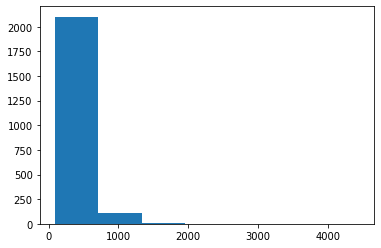

In [22]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7);

In [23]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

731

In [24]:
# Maximum sentence length in the training set
max(sent_lens)

4449

## Find Vocab Length

In [25]:
vocab = set()

for sent in df['text']:
  for word in sent.split():
    if word not in vocab:
      vocab.add(word)

In [26]:
len(vocab)

30346

# Text Vectorizer

In [27]:
# How many words are in our vocabulary
max_tokens = 30346

In [28]:
# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens,
                                    output_sequence_length=output_seq_len)

In [29]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(X_train)

In [30]:
X_train[1]

'worldcom boss  left books alone  former worldcom boss bernie ebbers  who is accused of overseeing an bn £bn fraud  never made accounting decisions  a witness has told jurors  david myers made the comments under questioning by defence lawyers who have been arguing that mr ebbers was not responsible for worldcom s problems the phone company collapsed in  and prosecutors claim that losses were hidden to protect the firm s shares mr myers has already pleaded guilty to fraud and is assisting prosecutors  on monday  defence lawyer reid weingarten tried to distance his client from the allegations during cross examination  he asked mr myers if he ever knew mr ebbers  make an accounting decision    not that i am aware of   mr myers replied  did you ever know mr ebbers to make an accounting entry into worldcom books   mr weingarten pressed  no   replied the witness mr myers has admitted that he ordered false accounting entries at the request of former worldcom chief financial officer scott sull

# Custom Embedding

In [31]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding") 

# Create Dataset

In [32]:
# Turn our data into TensorFlow Datasets
import tensorflow as tf 

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_encoded))
valid_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_encoded))
# test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [33]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Create Callbacks

## 1 . Early Stopping

In [34]:
# Create Early Stopping Callbackss
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                          #  min_delta=0.05,
                                                           patience=3, restore_best_weights=True)

## 2 . Model Checkpoints

In [35]:
# Set Checkpoint paths
checkpoint_path = 'Checkpoints_weights/model_0.ckpt'

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq='epoch', # save ever epoch
                                                         verbose=1)

## 3 . TensorBoard

Note : Already imported with helper functions so need to use it 

create_tensorboard_callback(dir_name='transfer_learning',
                            experiment_name='1_percent_data_aug')

# Model 0: Baseline

In [42]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(len(class_names), activation="softmax")(x)
model_0 = tf.keras.Model(inputs, outputs)

# Compile
model_0.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"],
                )

In [44]:
# Fit the model
model_0_history = model_0.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=100,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)),
                              callbacks = [early_stopping_callback,
                             checkpoint_callback,
                             create_tensorboard_callback(dir_name='NLP_Question1', experiment_name='model_0')] )

Saving TensorBoard log files to: NLP_Question1/model_0/20230226-204827
Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 1.5485 - accuracy: 0.4187
Epoch 1: saving model to Checkpoints_weights/model_0.ckpt
5/5 [==============================] - 2s 442ms/step - loss: 1.5485 - accuracy: 0.4187 - val_loss: 1.6025 - val_accuracy: 0.1875
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 1.5416 - accuracy: 0.3625
Epoch 2: saving model to Checkpoints_weights/model_0.ckpt
5/5 [==============================] - 2s 407ms/step - loss: 1.5416 - accuracy: 0.3625 - val_loss: 1.5930 - val_accuracy: 0.1562
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 1.5237 - accuracy: 0.3000
Epoch 3: saving model to Checkpoints_weights/model_0.ckpt
5/5 [==============================] - 1s 193ms/step - loss: 1.5237 - accuracy: 0.3000 - val_loss: 1.5685 - val_accuracy: 0.1875
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 1.5124 - accuracy: 0.3


Epoch 12: saving model to Checkpoints_weights/model_0.ckpt
5/5 [==============================] - 1s 201ms/step - loss: 1.1730 - accuracy: 0.7000 - val_loss: 1.0970 - val_accuracy: 0.6562


## Evaluation 

In [45]:
# Evaluate the model
model_0.evaluate(valid_dataset)

14/14 [==============================] - 1s 90ms/step - loss: 1.0934 - accuracy: 0.6876


[1.0934487581253052, 0.6876404285430908]

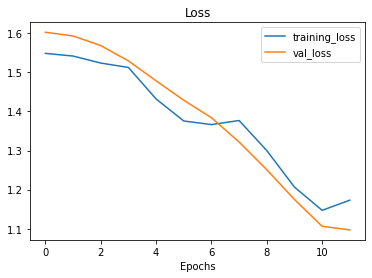

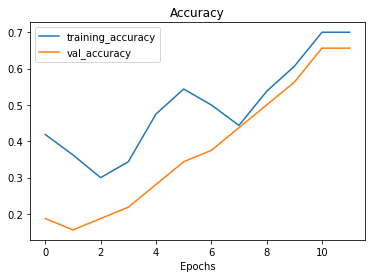

In [50]:
plot_loss_curves(model_0_history)

# Model 1: USE

In [51]:
import tensorflow_hub as hub
embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')

In [52]:
# Create Keras layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name='USE')

In [56]:
# Create model using the Sequential API
model_1 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64,activation='relu'),
    layers.Dense(5,activation='sigmoid',name='output_layer')
],name='model_1_USE')

# Compile
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [57]:
# Summary
model_1.summary()

Model: "model_1_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 output_layer (Dense)        (None, 5)                 325       
                                                                 
Total params: 256,830,981
Trainable params: 33,157
Non-trainable params: 256,797,824
_________________________________________________________________


In [63]:
# Train a classifier on top of USE pretrained embeddings
history_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=100,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)),
                              callbacks = [early_stopping_callback,
                             checkpoint_callback),
                             create_tensorboard_callback(dir_name='NLP_Question1', experiment_name='model_1')] )

TypeError: ignored

## Evaluate

In [59]:
model_1.evaluate(valid_dataset)

14/14 [==============================] - 1s 105ms/step - loss: 0.7597 - accuracy: 0.9416


[0.7597264051437378, 0.9415730237960815]

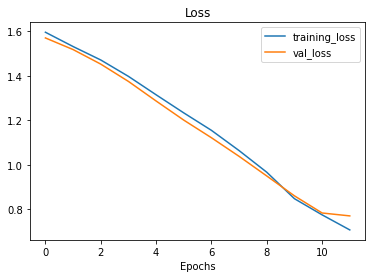

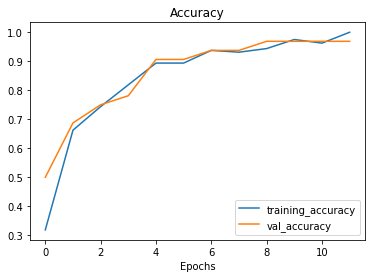

In [60]:
plot_loss_curves(history_1)

# Checking Tensorboard

In [62]:
# View tensorboad logs of transfer learning modelling experiments
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./NLP_Question1 \
  --name 'NLP_Question1' \
  --one_shot # exits the uploader once its finished uploading
  # --description 'A series of differen transfer leanring experiments with varying amounts of data fine-tuning' \
  # --one_shot # exits the uploader once its finished uploading

2023-02-26 21:11:37.944555: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-26 21:11:37.944646: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-02-26 21:11:37.944662: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2023-02-26 21:11:39.494362: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to c

# Save the Model

In [64]:
# Save TF Hub Sentence Encoder to HDF5 format
model_1.save('model_1.h5')

In [65]:
# Load model with custom Hub Layer (required HDF5 format)
import tensorflow_hub as hub
loaded_model_1 = tf.keras.models.load_model('model_1.h5',
                                      custom_objects={'KerasLayer':hub.KerasLayer})

In [67]:
# How does our loaded model perform?
loaded_model_1.evaluate(valid_dataset)

14/14 [==============================] - 2s 92ms/step - loss: 0.7597 - accuracy: 0.9416


[0.7597264051437378, 0.9415730237960815]

# Predict

In [68]:
model_1_pred_probs = model_1.predict(valid_dataset)

14/14 [==============================] - 9s 187ms/step


In [70]:
model_1_pred_probs[:5]

array([[0.46318504, 0.2849982 , 0.7643241 , 0.3331868 , 0.39904085],
       [0.7772025 , 0.3221833 , 0.57550913, 0.3275905 , 0.43635178],
       [0.35588232, 0.78142303, 0.2830445 , 0.5452486 , 0.45232195],
       [0.37119767, 0.44542995, 0.4425785 , 0.42117563, 0.68568844],
       [0.34395623, 0.4589206 , 0.38703743, 0.777545  , 0.35016114]],
      dtype=float32)

In [72]:
# Getting Labels
model_preds = tf.argmax(model_1_pred_probs,axis=1)

In [76]:
X_train[0] , y_train[0]

('tv future in the hands of viewers with home theatre systems  plasma highdefinition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices  one of the most talkedabout technologies of ces has been digital and personal video recorders dvr and pvr these settop boxes  like the us s tivo and the uk s sky system  allow people to record  store  play  pause and forward wind tv programmes when they want  essentially  the technology allows for much more personalised tv they are also being builtin to highdefinition t

In [75]:
# Testing out with our own issues
class_names[model_1.predict([X_train[0]]).argmax()]

1/1 [==============================] - 1s 941ms/step


'tech'

In [81]:
# Set Checkpoint paths
checkpoint_path = 'Checkpoints_weights/model_3.h5'

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq='epoch', # save ever epoch
                                                         verbose=1)

In [82]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(len(class_names), activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs)

# Compile
model_3.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"],
                )

In [83]:
# Fit the model
model_0_history = model_0.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=2,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)),
                               )

Epoch 1/2
5/5 [==============================] - 1s 247ms/step - loss: 0.8739 - accuracy: 0.7437 - val_loss: 1.0095 - val_accuracy: 0.5312
Epoch 2/2
5/5 [==============================] - 1s 194ms/step - loss: 0.8405 - accuracy: 0.7063 - val_loss: 0.9477 - val_accuracy: 0.5312


In [84]:
# Save TF Hub Sentence Encoder to HDF5 format
model_0.save('model_3.h5')

NotImplementedError: ignored